# 3. Joining & visualizing socioeconomic & vegetation data.

## Introduction

**Purpose:** Join the socioeconomic data (generated in `1-census-data-cleaning.ipynb`) and the vegetation density data (generated in `2-tract-vegetation.ipynb`) to identify and visualize census tract-level socioeconomic factors correlated to greenspace access.

**Contents:** The notebook shows:
* Data wrangling to enable a search for correlations between socioeconomic data & access to green space.
* Correlation coefficients for a variety of potentially relevant socioeconomic parameters & vegetation density data.
* Visualization of selected correlations.

**Conclusions:** Key conclusions & outputs are:
* In general, the census tracts with a greater density of green space (that is, have a higher NDVI) typically have a low population density and residents who tend to:
    * have a relatively high income
    * be predominantly white
    * be 55+ years old
    * have resided in their current residence for 20+ years
* Plots are shown for each of the correlations listed above.
* The listed correlations are also exported in a single CSV, `greenspace_highlights.csv`.
    * Each row is a single census tract in LA or Orange county.

## Import required libraries

In [1]:
# For manipulating tabular data
import pandas as pd

In [2]:
# For connecting to the SQLite database
from sqlalchemy import create_engine

In [3]:
# For correlation coefficients with statistical significance
from scipy.stats import pearsonr, spearmanr

In [4]:
# For plotting
import seaborn as sns
import matplotlib.pyplot as plt

## Function for statistical significance

By default, pandas `corr` method does not include a p-value to help indicate if the correlation coefficient is statistically signifant. Before calculating any correlation coefficients, define a function to return the correlation coefficient's corresponding p value.

In [5]:
def pearson_pval(x, y):
    # returns Pearson correlation coefficient followed by its associated p-value
    return pearsonr(x,y)[1]

## Demographics & vegetation density

### Join the data

Basic demographic data is stored in the `grenspace.db` SQLite database in the `demographics` table, and vegetation density data is in the `ndvi` table. These should be joined on each tract's unique FIPS code, `Tract_FIPS`.

In [6]:
demo_query = "SELECT demographics.*, ndvi.NDVI_20210517, ndvi.Land_area_m2 FROM demographics INNER JOIN ndvi ON demographics.Tract_FIPS = ndvi.Tract_FIPS"

In [7]:
with create_engine("sqlite:///greenspace.db").connect() as db:
    demo = pd.read_sql(demo_query, db, index_col = "Tract_FIPS")

In [8]:
demo.head()

,Geography,Geographic_Area_Name,Total_Population,Population_Male,Population_Female,Population_Under_5_years_old,Population_5to9_years_old,Population_10to14_years_old,Population_15to19_years_old,Population_20to24_years_old,...,Race_one_Other,Race_two+_white_and_black_or_African_American,Race_two+_white_and_Native_American,Race_two+_white_and_Asian,Race_two+_black_and_Native_American,Race_Hispanic_or_Latino,Race_Not_Hispanic_or_Latino,County,NDVI_20210517,Land_area_m2
Tract_FIPS,,,,,,,,,,,,,,,,,,,,,
06037262601,1400000US06037262601,"Census Tract 2626.01, Los Angeles County, Cali...",3478,1762,1716,239,193,279,146,131,...,61,0,60,205,0,136,3342,Los Angeles,0.469434,3620351
06037300100,1400000US06037300100,"Census Tract 3001, Los Angeles County, California",6279,3161,3118,326,459,567,267,258,...,107,0,0,113,0,838,5441,Los Angeles,0.418855,4591342
06037300501,1400000US06037300501,"Census Tract 3005.01, Los Angeles County, Cali...",3039,1470,1569,191,223,160,199,163,...,225,0,19,310,0,563,2476,Los Angeles,0.265917,1260255
06037310701,1400000US06037310701,"Census Tract 3107.01, Los Angeles County, Cali...",2121,1111,1010,56,74,81,63,163,...,147,47,7,33,0,279,1842,Los Angeles,0.156655,515339
06037300200,1400000US06037300200,"Census Tract 3002, Los Angeles County, California",5378,2665,2713,419,366,263,258,282,...,164,0,0,186,0,550,4828,Los Angeles,0.339691,1943986


In [9]:
list(demo.columns)

['Geography',
 'Geographic_Area_Name',
 'Total_Population',
 'Population_Male',
 'Population_Female',
 'Population_Under_5_years_old',
 'Population_5to9_years_old',
 'Population_10to14_years_old',
 'Population_15to19_years_old',
 'Population_20to24_years_old',
 'Population_25to34_years_old',
 'Population_35to44_years_old',
 'Population_45to54_years_old',
 'Population_55to59_years_old',
 'Population_60to64_years_old',
 'Population_65to74_years_old',
 'Population_75to84_years_old',
 'Population_85+_years_old',
 'Race_One_Race',
 'Race_Two_or_More_Races',
 'Race_one_white',
 'Race_one_black_or_African_American',
 'Race_one_native_American',
 'Race_one_black_or_Asian',
 'Race_one_Pacific_Islander',
 'Race_one_Other',
 'Race_two+_white_and_black_or_African_American',
 'Race_two+_white_and_Native_American',
 'Race_two+_white_and_Asian',
 'Race_two+_black_and_Native_American',
 'Race_Hispanic_or_Latino',
 'Race_Not_Hispanic_or_Latino',
 'County',
 'NDVI_20210517',
 'Land_area_m2']

Several of these features would be more meaningful as percentages rather than absolute numbers (such as "population 85+ years old" and "race"). Before proceeding, convert these features into percentages.

In [10]:
percent_cols = [feature for feature in list(demo.columns) if feature not in ["Geography", "Geographic_Area_Name", "Total_Population", "County", "NDVI_20210517", "Land_area_m2"]]
len(percent_cols)

29

In [11]:
for feature in percent_cols:
    newcol = feature + "_percent"
    demo[newcol] = demo[feature] / demo["Total_Population"] * 100
demo = demo.drop(percent_cols, axis = "columns")

Additionally, population density will be an important metric to consider. We'll compute this as the number of people per square kilometer.

In [12]:
demo["Pop_density_per_km2"] = demo["Total_Population"] / demo["Land_area_m2"] * 1000000 # Because there are 1 million m2 per 1 km2.
demo["Pop_density_per_km2"].describe()

count     3108.000000
mean      4899.947382
std       4320.358232
min          0.000000
25%       2338.160762
50%       3826.323028
75%       6277.450758
max      51699.625178
Name: Pop_density_per_km2, dtype: float64

### Examine for correlations

With the demographic data converted to percentages & merged with vegetation density, we can examine correlation coefficients to determine which demographic parameters are linked to vegetation density, if any.

In [13]:
demo_rvals = demo.corr(method = "pearson")["NDVI_20210517"]
demo_rvals.name = "Pearson_r_value"

In [14]:
demo_pvals = demo.corr(method = pearson_pval)["NDVI_20210517"]
demo_pvals.name = "p_value"

In [15]:
pd.DataFrame(demo_rvals).join(demo_pvals)

,Pearson_r_value,p_value
Total_Population,0.081489,5.322768e-06
NDVI_20210517,1.000000,1.000000e+00
Land_area_m2,0.067464,1.657167e-04
Population_Male_percent,-0.117034,6.730985e-11
Population_Female_percent,0.117034,6.730985e-11
Population_Under_5_years_old_percent,-0.115724,1.096632e-10
Population_5to9_years_old_percent,-0.119975,2.205503e-11
Population_10to14_years_old_percent,-0.046954,9.031360e-03
Population_15to19_years_old_percent,0.015753,3.812971e-01
Population_20to24_years_old_percent,-0.164951,2.697930e-20


While almost all of these correlation coefficients are statistically meaningful (p < 0.05), a few of the correlations stand out as being stronger than the rest. **The following parameters moderately correlate to increased vegetation density (i.e.: more access to green space):**
* A greater percentage of residents aged 44 years or older
* A greater percentage of white residents
* A lower percentage of black / African American and Latinx / Hispanic residents
* Lower population density

It would be nice if a continous paramater like "median age" was included in the American Community Survey data in addition to percentage breakdowns within given age ranges, but it is not.

### Visualize correlations

Let's visualize these correlations to ensure that they are realistic, meaningful, and consistent across LA and Orange Counties. There is currently a possibility that the correlations are skewed by the Orange County being generally greener, older, and more white than LA county.

#### Age vs. green space

The most visually meaningful way to represent this data will be to make a series of scatterplots with 3 variables: the x axis will be the percentage of each census tract made up by each age range, the y axis will be the tract's average vegetation density, and the points will be separated by county.

This is going to require a little bit of restructuring of the `demo` dataframe. We'll call the restructured version `agegroups`.

In [16]:
plot_ages = ["Population_20to24_years_old_percent",
             "Population_25to34_years_old_percent",
             "Population_35to44_years_old_percent",
             "Population_45to54_years_old_percent",
             "Population_55to59_years_old_percent",
             "Population_60to64_years_old_percent",
             "Population_75to84_years_old_percent",
             "Population_85+_years_old_percent"]

In [17]:
agegroups = pd.DataFrame(columns = ["Tract_FIPS", "NDVI_20210517", "County", "Percent_in_range", "Age_range"])
for agerange in plot_ages:
    filtered = demo[[ "County", agerange, "NDVI_20210517"]].reset_index()
    filtered.columns = ["Tract_FIPS", "County", "Percent_in_range", "NDVI_20210517"]
    filtered["Age_range"] = agerange
    agegroups = pd.concat([agegroups, filtered], axis = "index")
agegroups

,Tract_FIPS,NDVI_20210517,County,Percent_in_range,Age_range
0,06037262601,0.469434,Los Angeles,3.766532,Population_20to24_years_old_percent
1,06037300100,0.418855,Los Angeles,4.108935,Population_20to24_years_old_percent
2,06037300501,0.265917,Los Angeles,5.363606,Population_20to24_years_old_percent
3,06037310701,0.156655,Los Angeles,7.685054,Population_20to24_years_old_percent
4,06037300200,0.339691,Los Angeles,5.243585,Population_20to24_years_old_percent
...,...,...,...,...,...
3107,06037194500,0.236579,Los Angeles,2.318841,Population_85+_years_old_percent
3108,06037195100,0.338942,Los Angeles,3.312151,Population_85+_years_old_percent
3109,06037195300,0.222636,Los Angeles,2.680486,Population_85+_years_old_percent
3110,06037137501,0.342530,Los Angeles,3.368862,Population_85+_years_old_percent


With the age data restructured, we are ready to make the plot.

In [18]:
sns.set_theme(context = "notebook")

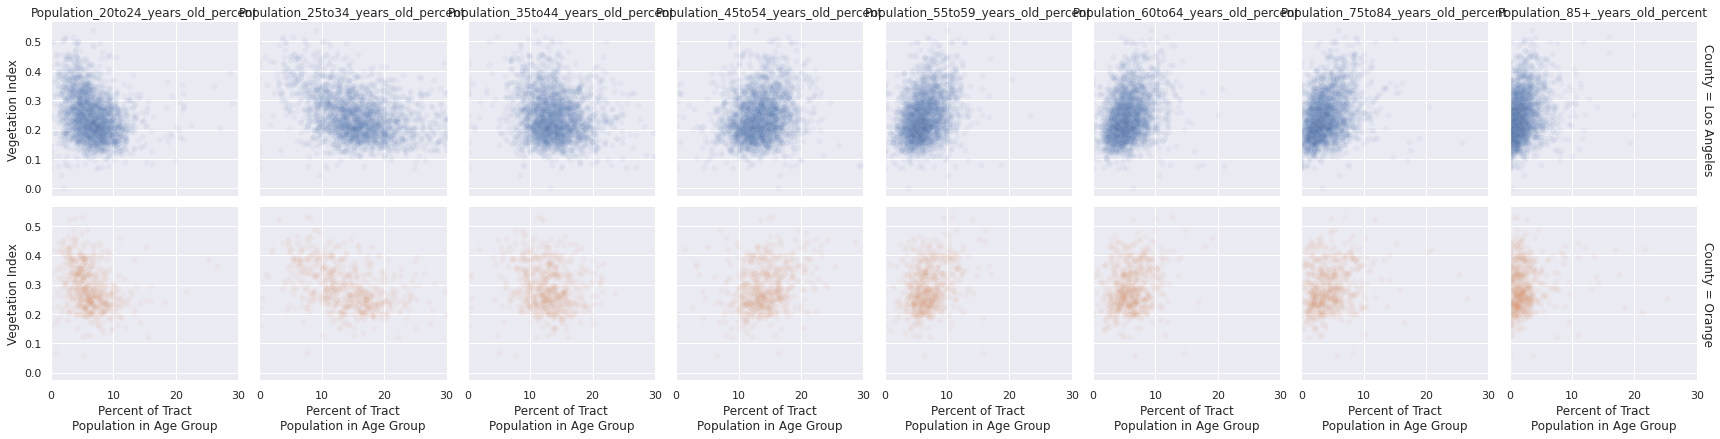

In [19]:
ageplot = sns.FacetGrid(data = agegroups, row = "County", col = "Age_range",  hue = "County", margin_titles = True, xlim = (0, 30))
ageplot.map(sns.scatterplot, "Percent_in_range", "NDVI_20210517", alpha = 0.05)
ageplot.set_titles(col_template = "{col_name}")
ageplot.set_axis_labels("Percent of Tract\nPopulation in Age Group", "Vegetation Index")

Now it is very clear that these correlations are similar across LA and Orange counties: The 20-34 year-old demographics are negatively correlated to green space. This correlation levels off and then reverses in the 35-54 age group, and then is positively correlated  in the 55+ age range.

That said, this plot is pretty ugly due to the overlapping titles and a little overwhelming due to its sheer size. This information will be more clear if the ages are presented at a more coarse level in those three ranges rather than 8 separate age groups. Reorganize the data to those 3 broad ranges in the `agegroups2` dataframe:

In [20]:
agegroups2 = pd.DataFrame()
agegroups2["20-34"] = demo["Population_20to24_years_old_percent"] + demo["Population_25to34_years_old_percent"]
agegroups2["35-54"] = demo["Population_35to44_years_old_percent"] + demo["Population_45to54_years_old_percent"]
agegroups2["55+"] = demo["Population_55to59_years_old_percent"] + demo["Population_60to64_years_old_percent"] + demo["Population_75to84_years_old_percent"] + demo["Population_85+_years_old_percent"]
agegroups2["NDVI_20210517"] = demo["NDVI_20210517"]
agegroups2["County"] = demo["County"]

In [21]:
agegroups2

,20-34,35-54,55+,NDVI_20210517,County
Tract_FIPS,,,,,
06037262601,11.040828,24.583094,26.135710,0.469434,Los Angeles
06037300100,10.766046,28.666985,21.054308,0.418855,Los Angeles
06037300501,14.511352,31.359000,19.315564,0.265917,Los Angeles
06037310701,23.856671,21.499293,29.467232,0.156655,Los Angeles
06037300200,13.834139,25.734474,25.529937,0.339691,Los Angeles
...,...,...,...,...,...
06037194500,26.473430,29.227053,19.661836,0.236579,Los Angeles
06037195100,13.864818,37.011361,19.006355,0.338942,Los Angeles
06037195300,32.273052,33.130808,17.726948,0.222636,Los Angeles


For convenience of plotting, we'll again restructure this to a longer format (`agegroups3`) to make use of Seaborn's FacetGrid feature:

In [22]:
agegroups3 = pd.DataFrame(columns = ["Tract_FIPS", "County", "NDVI_20210517", "Percent_in_range", "Age_range"])
plot_ages = ["20-34", "35-54", "55+"]
for agerange in plot_ages:
    filtered = agegroups2[[agerange, "NDVI_20210517", "County"]].reset_index()
    filtered.columns = ["Tract_FIPS", "Percent_in_range", "NDVI_20210517", "County"]
    filtered["Age_range"] = agerange
    agegroups3 = pd.concat([agegroups3, filtered], axis = "index")
agegroups3

,Tract_FIPS,County,NDVI_20210517,Percent_in_range,Age_range
0,06037262601,Los Angeles,0.469434,11.040828,20-34
1,06037300100,Los Angeles,0.418855,10.766046,20-34
2,06037300501,Los Angeles,0.265917,14.511352,20-34
3,06037310701,Los Angeles,0.156655,23.856671,20-34
4,06037300200,Los Angeles,0.339691,13.834139,20-34
...,...,...,...,...,...
3107,06037194500,Los Angeles,0.236579,19.661836,55+
3108,06037195100,Los Angeles,0.338942,19.006355,55+
3109,06037195300,Los Angeles,0.222636,17.726948,55+
3110,06037137501,Los Angeles,0.342530,16.330415,55+


And plot it:

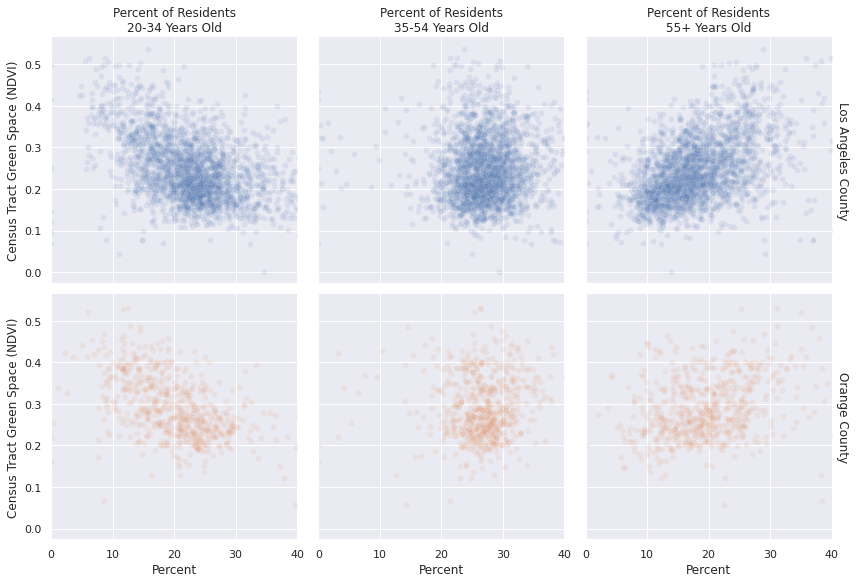

In [23]:
ageplot2 = sns.FacetGrid(data = agegroups3, row = "County", col = "Age_range", hue = "County", margin_titles = True, xlim = (0, 40), height = 4, aspect = 1)
ageplot2.map(sns.scatterplot, "Percent_in_range", "NDVI_20210517", alpha = 0.1)
ageplot2.set_titles(col_template = "Percent of Residents\n{col_name} Years Old", row_template = "{row_name} County")
ageplot2.set_axis_labels("Percent", "Census Tract Green Space (NDVI)")

This 3x2 plot is a step in the right direction from the original 8x2 plot. However, it is still not immediately intuitive. Let's try a single scatterplot with the 20-34 population on one axis, the 55+ population on another axis, and a color gradient to represent vegetation density.

/home/josh/miniconda3/envs/rem-sense/lib/python3.10/site-packages/seaborn/utils.py:478: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


Text(2, 2, 'Each point represents one census tract in LA or Orange counties.')

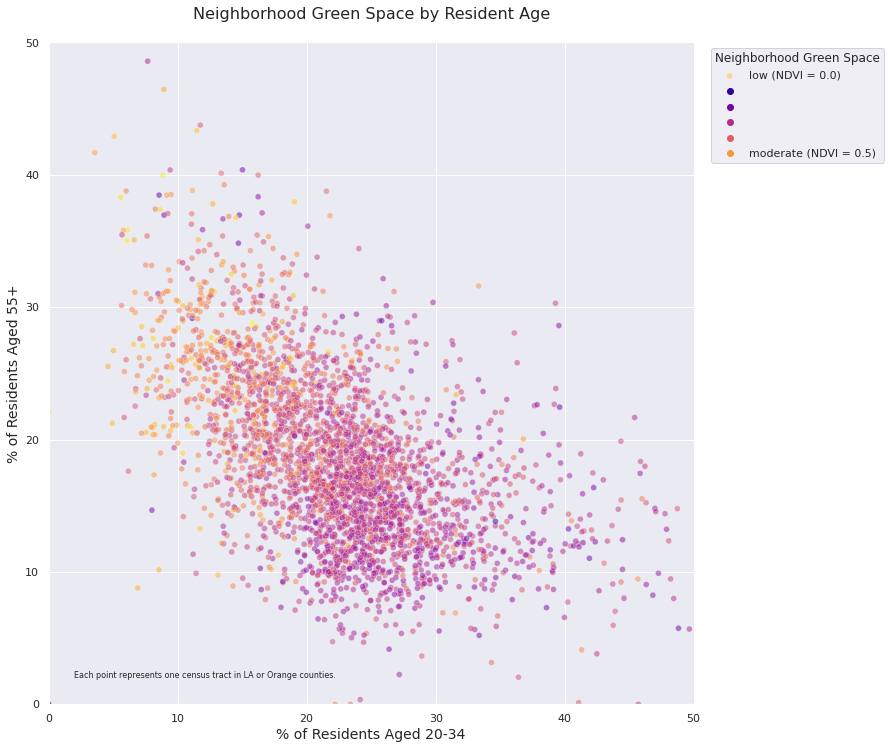

In [24]:
ageplot3 = sns.relplot(kind = "scatter",
                       data = agegroups2,
                       x = "20-34",
                       y = "55+",
                       hue = "NDVI_20210517",
                       height = 10,
                       aspect = 1,
                       palette = "plasma",
                       alpha = 0.5)
sns.move_legend(ageplot3,
                loc = "upper right",
                bbox_to_anchor = (1.1, .985),
                title = "Neighborhood Green Space",
                labels = ["low (NDVI = 0.0)", "", "", "", "", "moderate (NDVI = 0.5)"],
                frameon = True)
ageplot3.set(xlim = (0, 50),
             ylim = (0, 50))
plt.xlabel("% of Residents Aged 20-34", fontsize = 14)
plt.ylabel("% of Residents Aged 55+", fontsize = 14)
plt.title("Neighborhood Green Space by Resident Age\n", fontsize = 16)
plt.annotate("Each point represents one census tract in LA or Orange counties.",
             xy = (2, 2),
             horizontalalignment = "left",
             size = 8)

#### Race vs. green space

Text(2, 0.015, 'Each point represents one census tract in LA or Orange counties.')

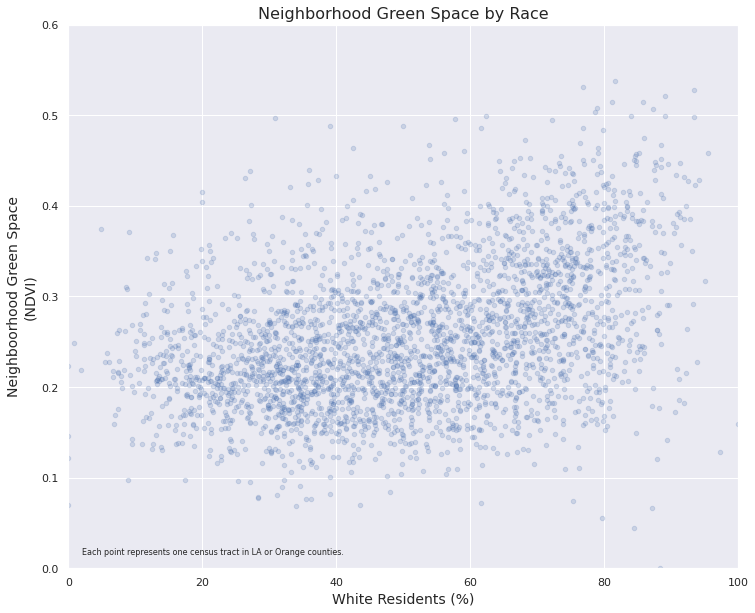

In [25]:
raceplot = demo.plot(kind = "scatter",
                      x = "Race_one_white_percent",
                      y = "NDVI_20210517",
                      sharex = False,
                      figsize = (12, 10),
                      alpha = 0.2)
raceplot.set(ylim = (0, 0.6),
               xlim = (0, 100))
plt.xlabel("White Residents (%)", fontsize = 14)
plt.ylabel("Neighboorhood Green Space\n(NDVI)", fontsize = 14)
plt.title("Neighborhood Green Space by Race", fontsize = 16)
plt.annotate("Each point represents one census tract in LA or Orange counties.",
             xy = (2, 0.015),
             horizontalalignment = "left",
             size = 8)

In [26]:
raceplot.get_figure().savefig("images/race.png")

#### Population density vs. green space

Text(200, 0.015, 'Each point represents one census tract in LA or Orange counties.')

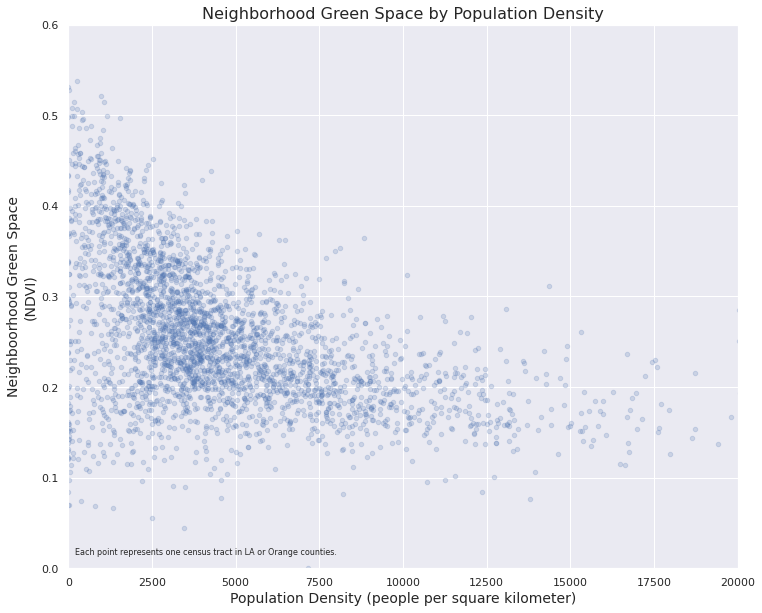

In [27]:
densityplot = demo.plot(kind = "scatter",
                      x = "Pop_density_per_km2",
                      y = "NDVI_20210517",
                      sharex = False,
                      figsize = (12, 10),
                      alpha = 0.2)
densityplot.set(ylim = (0, 0.6),
               xlim = (0, 20000)
             )
plt.xlabel("Population Density (people per square kilometer)", fontsize = 14)
plt.ylabel("Neighboorhood Green Space\n(NDVI)", fontsize = 14)
plt.title("Neighborhood Green Space by Population Density", fontsize = 16)
plt.annotate("Each point represents one census tract in LA or Orange counties.",
             xy = (200, 0.015),
             horizontalalignment = "left",
             size = 8)

In [28]:
densityplot.get_figure().savefig("images/pop_density.png")

## Economics & vegetation density

### Join the data

Socioeconomic data is stored in the `grenspace.db` SQLite database in the `economics` table. Like before, these should be joined on each tract's unique FIPS code, `Tract_FIPS`.

In [29]:
econ_query = "SELECT economics.*, ndvi.NDVI_20210517 FROM economics INNER JOIN ndvi ON economics.Tract_FIPS = ndvi.Tract_FIPS"

In [30]:
with create_engine("sqlite:///greenspace.db").connect() as db:
    econ = pd.read_sql(econ_query, db, index_col = "Tract_FIPS")

In [31]:
econ.describe()

,"Employed_population_16+_years,_all","Employed_population_16+_years,_female",Workers_who_commute_to_work_total,Workers_who_commute_to_work_drive_alone,Workers_who_commute_to_work_carpool,Workers_who_commute_to_work_public_transit,Workers_who_commute_to_work_walk,Workers_who_commute_to_work_other,Workers_who_commute_to_work_work_from_home,Mean_travel_time_to_work_minutes,Median_household_income_dollars,Mean_household_income_dollars,NDVI_20210517
count,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3075.000000,3063.000000,3076.000000,3112.000000
mean,3428.003213,1752.751928,2037.053985,1489.583226,193.438303,91.780848,48.883676,44.860219,168.507712,30.988520,81390.855697,105750.066645,0.253565
std,1286.096731,675.580335,813.261820,647.464887,133.028865,113.927106,95.538162,48.987282,150.640324,5.004802,36349.854207,53166.029967,0.078610
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.400000,4918.000000,8406.000000,-0.033600
25%,2571.500000,1306.750000,1495.500000,1054.000000,96.750000,19.000000,5.000000,11.000000,62.000000,27.700000,54257.000000,69997.000000,0.197994
50%,3294.000000,1696.000000,1979.500000,1428.000000,169.000000,56.000000,25.000000,31.000000,124.500000,30.900000,74219.000000,92869.500000,0.243018
75%,4177.250000,2152.250000,2485.500000,1867.250000,262.000000,120.250000,58.000000,63.000000,235.000000,34.000000,100782.500000,125954.250000,0.301188
max,15723.000000,8912.000000,7622.000000,5673.000000,1000.000000,1304.000000,2295.000000,577.000000,1846.000000,57.200000,250000.000000,440616.000000,0.538042


In [32]:
list(econ.columns)

['Geography',
 'Geographic_Area_Name',
 'Employed_population_16+_years,_all',
 'Employed_population_16+_years,_female',
 'Workers_who_commute_to_work_total',
 'Workers_who_commute_to_work_drive_alone',
 'Workers_who_commute_to_work_carpool',
 'Workers_who_commute_to_work_public_transit',
 'Workers_who_commute_to_work_walk',
 'Workers_who_commute_to_work_other',
 'Workers_who_commute_to_work_work_from_home',
 'Mean_travel_time_to_work_minutes',
 'Median_household_income_dollars',
 'Mean_household_income_dollars',
 'County',
 'NDVI_20210517']

Several of these features would be more meaningful as percentages rather than absolute numbers (such as "employed population" and "workers who commute"). Before proceeding, convert these features into percentages.

In [33]:
# Append the total population column so a percentage can be calculated
econ = econ.join(demo["Total_Population"])

In [34]:
percent_cols = [feature for feature in list(econ.columns) if feature not in ["Geography", "Geographic_Area_Name", "Mean_travel_time_to_work_minutes", "Median_household_income_dollars", "Mean_household_income_dollars", "County", "NDVI_20210517", "Total_Population"]]
len(percent_cols)

9

In [35]:
for feature in percent_cols:
    newcol = feature + "_percent"
    econ[newcol] = econ[feature] / econ["Total_Population"] * 100
econ = econ.drop(percent_cols, axis = "columns")

In [36]:
econ.head()

,Geography,Geographic_Area_Name,Mean_travel_time_to_work_minutes,Median_household_income_dollars,Mean_household_income_dollars,County,NDVI_20210517,Total_Population,"Employed_population_16+_years,_all_percent","Employed_population_16+_years,_female_percent",Workers_who_commute_to_work_total_percent,Workers_who_commute_to_work_drive_alone_percent,Workers_who_commute_to_work_carpool_percent,Workers_who_commute_to_work_public_transit_percent,Workers_who_commute_to_work_walk_percent,Workers_who_commute_to_work_other_percent,Workers_who_commute_to_work_work_from_home_percent
Tract_FIPS,,,,,,,,,,,,,,,,,
06037262601,1400000US06037262601,"Census Tract 2626.01, Los Angeles County, Cali...",29.7,201094.0,350487.0,Los Angeles,0.469434,3478,79.068430,39.016676,47.354802,36.946521,0.977573,0.000000,0.258769,0.000000,9.171938
06037300100,1400000US06037300100,"Census Tract 3001, Los Angeles County, California",34.9,140665.0,150385.0,Los Angeles,0.418855,6279,77.560121,41.089345,41.280459,33.731486,3.424112,0.238892,0.573340,0.063704,3.248925
06037300501,1400000US06037300501,"Census Tract 3005.01, Los Angeles County, Cali...",35.0,104926.0,121650.0,Los Angeles,0.265917,3039,79.894702,42.382363,48.206647,41.362290,3.126028,0.526489,0.723922,0.756828,1.711089
06037310701,1400000US06037310701,"Census Tract 3107.01, Los Angeles County, Cali...",22.4,21117.0,55440.0,Los Angeles,0.156655,2121,89.486091,43.564356,36.256483,25.223951,0.518623,0.141443,1.885903,2.121641,6.364922
06037300200,1400000US06037300200,"Census Tract 3002, Los Angeles County, California",31.4,106490.0,139377.0,Los Angeles,0.339691,5378,79.602083,41.242097,45.202678,37.783563,3.514318,0.223131,0.687988,0.446263,2.547415


### Examine for correlations

With the housing data merged with vegetation density, we can examine correlation coefficients to determine which housing-related parameters are linked to vegetation density, if any.

In [37]:
econ_rvals = econ.corr(method = "pearson")["NDVI_20210517"]
econ_rvals.name = "Pearson_r_value"

In [38]:
econ_pvals = econ.corr(method = pearson_pval)["NDVI_20210517"]
econ_pvals.name = "p_value"

In [39]:
pd.DataFrame(econ_rvals).join(econ_pvals)

,Pearson_r_value,p_value
Mean_travel_time_to_work_minutes,-0.081916,5.408551e-06
Median_household_income_dollars,0.656901,0.000000e+00
Mean_household_income_dollars,0.659217,0.000000e+00
NDVI_20210517,1.000000,1.000000e+00
Total_Population,0.081489,5.322768e-06
"Employed_population_16+_years,_all_percent",0.114072,2.014561e-10
"Employed_population_16+_years,_female_percent",0.167912,5.540385e-21
Workers_who_commute_to_work_total_percent,0.035841,4.631639e-02
Workers_who_commute_to_work_drive_alone_percent,0.191728,5.608038e-27
Workers_who_commute_to_work_carpool_percent,-0.187087,9.607929e-26


There are several weak but statistically meaningful correlations here. **The strongest, statistically significant correlations to greater green space access are:**
* Increased household income.
* Increased work-from-home status.
* Decreased use of public transit to commute to work.

Likely the latter two parameters (commuting status) are themselves related to household income.

### Visualize Correlations

Text(4000, 0.015, 'Each point represents one census tract in LA or Orange counties.')

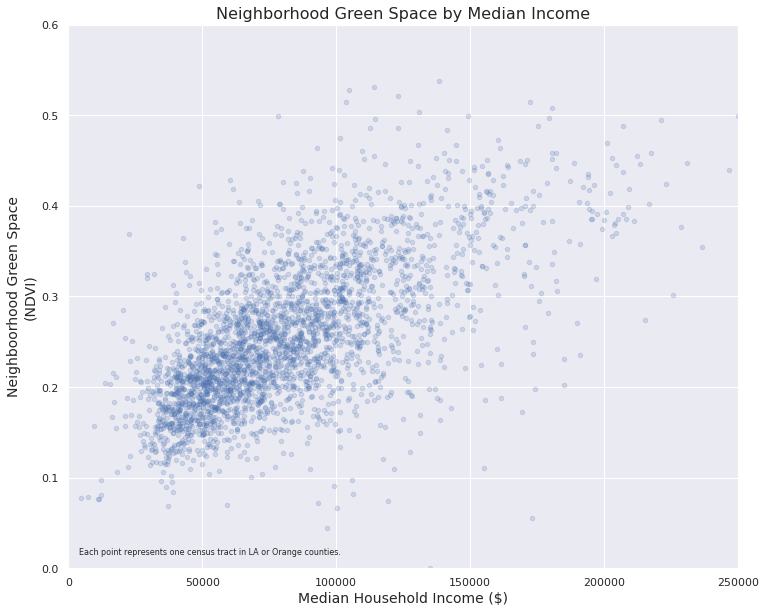

In [40]:
incomeplot = econ.plot(kind = "scatter",
                       x = "Median_household_income_dollars",
                       y = "NDVI_20210517",
                       sharex = False,
                       #gridsize = 50,
                       figsize = (12, 10),
                       alpha = 0.2)
incomeplot.set(ylim = (0, 0.6),
               xlim = (0, 250000))
plt.xlabel("Median Household Income ($)", fontsize = 14)
plt.ylabel("Neighboorhood Green Space\n(NDVI)", fontsize = 14)
plt.title("Neighborhood Green Space by Median Income", fontsize = 16)
plt.annotate("Each point represents one census tract in LA or Orange counties.",
             xy = (4000, 0.015),
             horizontalalignment = "left",
             size = 8)

In [41]:
incomeplot.get_figure().savefig("images/income.png")

## Housing & vegetation density

### Join the data

Housing data is stored in the same SQLite database in the `housing` table.

In [42]:
housing_query = "SELECT housing.*, ndvi.NDVI_20210517 FROM housing INNER JOIN ndvi ON housing.Tract_FIPS = ndvi.Tract_FIPS"

In [43]:
with create_engine("sqlite:///greenspace.db").connect() as db:
    housing = pd.read_sql(housing_query, db, index_col = "Tract_FIPS")

In [44]:
housing.head()

,Geography,Geographic_Area_Name,Housing_units_total,Housing_units_occupied,Housing_units_vacant,Vacancy_rate_homeowner,Vacancy_rate_rental,"Housing_units_in_structure_1,_detached","Housing_units_in_structure_1,_attached",Housing_units_in_structure__2,...,"Monthly_rent,_500_to_1k_dollars,_count","Monthly_rent,_1k_to_1.5k_dollars,_count","Monthly_rent,_1.5k_to_2k_dollars,_count","Monthly_rent,_2k_to_2.5k_dollars,_count","Monthly_rent,_2.5k_to_3k_dollars,_count","Monthly_rent,_more_than_3k_dollars,_count","Monthly_rent,_median_dollars","Monthly_rent,_no_rent_paid",County,NDVI_20210517
Tract_FIPS,,,,,,,,,,,,,,,,,,,,,
06037262601,1400000US06037262601,"Census Tract 2626.01, Los Angeles County, Cali...",1363,1290,73,0.0,0.0,877,442,0,...,0,0,9,0,0,106,NaN,0,Los Angeles,0.469434
06037300100,1400000US06037300100,"Census Tract 3001, Los Angeles County, California",2196,2079,117,0.0,0.0,2073,40,0,...,84,0,0,101,17,69,2255.0,19,Los Angeles,0.418855
06037300501,1400000US06037300501,"Census Tract 3005.01, Los Angeles County, Cali...",1079,1047,32,0.0,0.0,905,40,48,...,0,31,110,76,25,36,1991.0,7,Los Angeles,0.265917
06037310701,1400000US06037310701,"Census Tract 3107.01, Los Angeles County, Cali...",1142,1102,40,0.0,3.7,22,14,0,...,106,274,169,79,31,0,1211.0,23,Los Angeles,0.156655
06037300200,1400000US06037300200,"Census Tract 3002, Los Angeles County, California",1979,1853,126,0.6,0.0,1573,78,43,...,8,67,161,89,0,203,2112.0,13,Los Angeles,0.339691


In [45]:
list(housing.columns)

['Geography',
 'Geographic_Area_Name',
 'Housing_units_total',
 'Housing_units_occupied',
 'Housing_units_vacant',
 'Vacancy_rate_homeowner',
 'Vacancy_rate_rental',
 'Housing_units_in_structure_1,_detached',
 'Housing_units_in_structure_1,_attached',
 'Housing_units_in_structure__2',
 'Housing_units_in_structure_3to4',
 'Housing_units_in_structure_5to9',
 'Housing_units_in_structure_10to19',
 'Housing_units_in_structure_20+',
 'Housing_units_in_structure_mobile_home',
 'Housing_units_in_structure_RV,_boat,_etc',
 'Year_of_housing_structures_built_after_2014',
 'Year_of_housing_structures_built_2010to2013',
 'Year_of_housing_structures_built_2000to2009',
 'Year_of_housing_structures_built_1990to1999',
 'Year_of_housing_structures_built_1980to1989',
 'Year_of_housing_structures_built_1970to1979',
 'Year_of_housing_structures_built_1960to1969',
 'Year_of_housing_structures_built_1950to1959',
 'Year_of_housing_structures_built_1940to1949',
 'Year_of_housing_structures_built_1939_or_before

A few of these features would be more meaningful as percentages rather than absolute numbers (such as "occupied housing units" and "count of owner-occupied units"). Before proceeding, convert these features into percentages.

In [46]:
percent_cols = ["Housing_units_occupied",
                "Housing_units_vacant",
                "Housing_units_in_structure_1,_detached",
                "Housing_units_in_structure_1,_attached",
                "Housing_units_in_structure__2",
                "Housing_units_in_structure_3to4",
                "Housing_units_in_structure_5to9",
                "Housing_units_in_structure_10to19",
                "Housing_units_in_structure_20+",
                "Housing_units_in_structure_mobile_home",
                "Housing_units_in_structure_RV,_boat,_etc",
                "Housing_occupancy_owner_occupied_count",
                "Housing_occupancy_renter_occupied_count",
                "Year_of_moving_into_household_2019_or_after_count",
                "Year_of_moving_into_household_2015to2018_count",
                "Year_of_moving_into_household_2010to2014_count",
                "Year_of_moving_into_household_2000to2009_count",
                "Year_of_moving_into_household_1990to1999_count_",
                "Year_of_moving_into_household_1989_or_earlier_count",
                "Ownertooccupied_Unit_value,_less_than_50k_dollars_count",
                "Ownertooccupied_Unit_value,_50_to_100k_dollars_count",
                "Ownertooccupied_Unit_value,_100_to_150k_dollars_count",
                "Ownertooccupied_Unit_value,_150_to_200k_dollars_count",
                "Ownertooccupied_Unit_value,_200_to_300k_dollars_count",
                "Ownertooccupied_Unit_value,_300_to_500k_dollars_count",
                "Ownertooccupied_Unit_value,_500_to_1000k_dollars_count",
                "Ownertooccupied_Unit_value,_more_than_1000k_dollars_count",
                "Monthly_rent,_less_than_500_dollars,_count",
                "Monthly_rent,_500_to_1k_dollars,_count",
                "Monthly_rent,_1k_to_1.5k_dollars,_count",
                "Monthly_rent,_1.5k_to_2k_dollars,_count",
                "Monthly_rent,_2k_to_2.5k_dollars,_count",
                "Monthly_rent,_2.5k_to_3k_dollars,_count",
                "Monthly_rent,_more_than_3k_dollars,_count",
                "Monthly_rent,_no_rent_paid",
                "Year_of_housing_structures_built_after_2014",
                "Year_of_housing_structures_built_2010to2013",
                "Year_of_housing_structures_built_2000to2009",
                "Year_of_housing_structures_built_1990to1999",
                "Year_of_housing_structures_built_1980to1989",
                "Year_of_housing_structures_built_1970to1979",
                "Year_of_housing_structures_built_1960to1969",
                "Year_of_housing_structures_built_1950to1959",
                "Year_of_housing_structures_built_1940to1949",
                "Year_of_housing_structures_built_1939_or_before"
               ]

In [47]:
for feature in percent_cols:
    newcol = feature + "_percent"
    housing[newcol] = housing[feature] / housing["Housing_units_total"] * 100
housing = housing.drop(percent_cols, axis = "columns")

In [48]:
housing.head()

,Geography,Geographic_Area_Name,Housing_units_total,Vacancy_rate_homeowner,Vacancy_rate_rental,"Housing,_median_number_rooms","Ownertooccupied_Unit_value,_median_dollars","Monthly_rent,_median_dollars",County,NDVI_20210517,...,Year_of_housing_structures_built_after_2014_percent,Year_of_housing_structures_built_2010to2013_percent,Year_of_housing_structures_built_2000to2009_percent,Year_of_housing_structures_built_1990to1999_percent,Year_of_housing_structures_built_1980to1989_percent,Year_of_housing_structures_built_1970to1979_percent,Year_of_housing_structures_built_1960to1969_percent,Year_of_housing_structures_built_1950to1959_percent,Year_of_housing_structures_built_1940to1949_percent,Year_of_housing_structures_built_1939_or_before_percent
Tract_FIPS,,,,,,,,,,,,,,,,,,,,,
06037262601,1400000US06037262601,"Census Tract 2626.01, Los Angeles County, Cali...",1363,0.0,0.0,7.5,NaN,NaN,Los Angeles,0.469434,...,0.000000,0.000000,6.309611,20.542920,18.561996,50.550257,1.173881,2.861335,0.000000,0.000000
06037300100,1400000US06037300100,"Census Tract 3001, Los Angeles County, California",2196,0.0,0.0,6.3,991700.0,2255.0,Los Angeles,0.418855,...,0.000000,0.000000,1.183971,2.231330,6.876138,19.034608,24.134791,30.373406,5.601093,10.564663
06037300501,1400000US06037300501,"Census Tract 3005.01, Los Angeles County, Cali...",1079,0.0,0.0,5.3,696200.0,1991.0,Los Angeles,0.265917,...,0.000000,0.000000,5.282669,0.741427,3.336423,13.345690,7.970343,21.501390,32.715477,15.106580
06037310701,1400000US06037310701,"Census Tract 3107.01, Los Angeles County, Cali...",1142,0.0,3.7,2.9,582300.0,1211.0,Los Angeles,0.156655,...,0.000000,0.525394,8.056042,4.728546,15.586690,35.201401,20.490368,11.033275,1.663748,2.714536
06037300200,1400000US06037300200,"Census Tract 3002, Los Angeles County, California",1979,0.6,0.0,5.6,862000.0,2112.0,Los Angeles,0.339691,...,0.252653,0.656897,1.465387,5.608893,9.701870,4.295099,9.044972,35.876705,16.422436,16.675088


### Examine for correlations

With the housing data merged with vegetation density, we can examine correlation coefficients to determine which housing-related parameters are linked to vegetation density, if any.

In [49]:
housing_rvals = housing.corr(method = "pearson")["NDVI_20210517"]
housing_rvals.name = "Pearson_r_value"

In [50]:
housing_pvals = housing.corr(method = pearson_pval)["NDVI_20210517"]
housing_pvals.name = "p_value"

In [51]:
pd.DataFrame(housing_rvals).join(housing_pvals)

,Pearson_r_value,p_value
Housing_units_total,0.157051,1.225722e-18
Vacancy_rate_homeowner,-0.036417,4.470829e-02
Vacancy_rate_rental,0.048762,6.804557e-03
"Housing,_median_number_rooms",0.572383,2.457963e-266
"Ownertooccupied_Unit_value,_median_dollars",0.445498,1.181269e-140
"Monthly_rent,_median_dollars",0.517239,1.586146e-202
NDVI_20210517,1.000000,1.000000e+00
Housing_units_occupied_percent,-0.031139,8.386206e-02
Housing_units_vacant_percent,0.031139,8.386206e-02
"Housing_units_in_structure_1,_detached_percent",0.433315,2.438029e-141


Virtually all of the correlation coefficients shown here are statistically meaningful. **However, the housing features that most strongly correlate to increased access to green space are:**
* Larger median home size (as the number of rooms).
* Greater median housing cost (as value for owner-occupied housing, or monthly rent for rental properties)
    * *This effect is especially pronounced for the most expensive owner-occupied units, as well as the least expensive rental units.*
* Lower density housing (as the number of housing units per structure)
* Greater percentage of long-term residents (before 1999 -- 22+ years)

Of these, I think that duration of residency is the most interesting; the others are likely a proxy for wealth or income, but it is non-obvious to me why length of residency should correlate to green space access. Let's examine that correlation more closely by plotting it.

### Visualize correlations

For the sake of clean plotting, let's first reduce the number of bins here to "percentage of residents who moved in before 2000" rather than using the 5-10 year increments in the ACS demographic data.

In [52]:
housing2 = pd.DataFrame()
housing2["Residency_before_2000_percent"] = housing["Year_of_moving_into_household_1990to1999_count__percent"] + housing["Year_of_moving_into_household_1989_or_earlier_count_percent"]
housing2["NDVI_20210517"] = housing["NDVI_20210517"]
housing2["County"] = demo["County"]
housing2.head()

,Residency_before_2000_percent,NDVI_20210517,County
Tract_FIPS,,,
06037262601,35.876742,0.469434,Los Angeles
06037300100,48.178506,0.418855,Los Angeles
06037300501,33.734940,0.265917,Los Angeles
06037310701,12.346760,0.156655,Los Angeles
06037300200,40.222335,0.339691,Los Angeles


Text(1, 0.015, 'Each point represents one census tract in LA or Orange counties.')

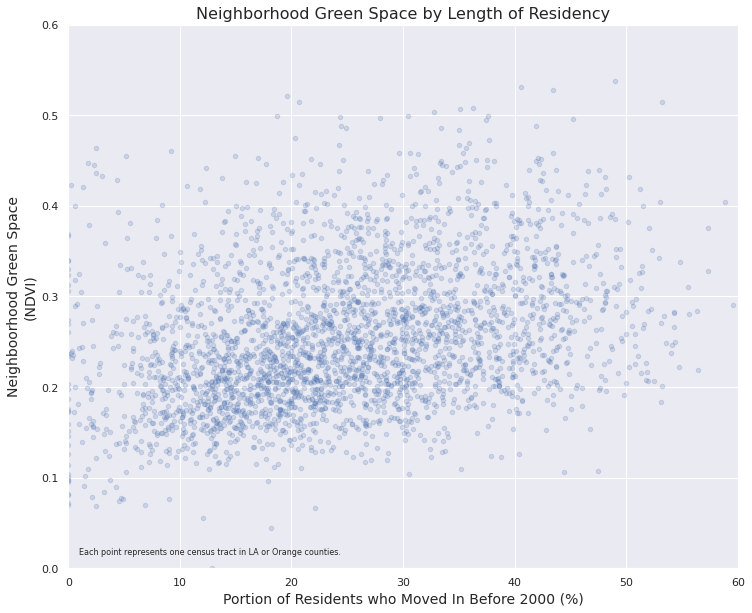

In [53]:
residencyplot = housing2.plot(kind = "scatter",
                              x = "Residency_before_2000_percent",
                              y = "NDVI_20210517",
                              sharex = False,
                              figsize = (12, 10),
                              alpha = 0.2)
residencyplot.set(ylim = (0, 0.6),
                  xlim = (0, 60))
plt.xlabel("Portion of Residents who Moved In Before 2000 (%)", fontsize = 14)
plt.ylabel("Neighboorhood Green Space\n(NDVI)", fontsize = 14)
plt.title("Neighborhood Green Space by Length of Residency", fontsize = 16)
plt.annotate("Each point represents one census tract in LA or Orange counties.",
             xy = (1, 0.015),
             horizontalalignment = "left",
             size = 8)

In [54]:
residencyplot.savefig("images/residency_length.png")

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

## Save the highlights
For convenience, gather all of the highlighted trends that were identied here into a single dataframe. Save the results to a CSV file.

In [ ]:
# Start by including the tract FIPS codes, NDVI vegetation data, and age demographics.
greenspace = agegroups2

In [ ]:
# Add race and population density
greenspace["Race_white_percent"] = demo["Race_one_white_percent"]
greenspace["Pop_density_per_km2"] = demo["Pop_density_per_km2"]

In [ ]:
# Add the percentage of residents who have lived there for many years.
greenspace["Residency_before_2000_percent"] = housing2["Residency_before_2000_percent"]

Clean up the column names for ease of understanding:

In [ ]:
greenspace.columns

In [ ]:
greenspace.columns = ["Age_20-34_percent",
                      "Age_35-54_percent",
                      "Age_55+_percent",
                      "NDVI_2021-05-17",
                      "County",
                      "Race_white_percent",
                      "Pop_density_per_km2",
                      "Residency_before_2000_percent"]

In [ ]:
greenspace.head()

In [ ]:
greenspace.to_csv("greenspace_highlights.csv")